In [2]:
import tensorflow as tf
import datetime, os
# hide tf logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'},
# 0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import pandas as pd
import seaborn as sns 
import codecs, json

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.0.0


# Data Prep

Training and Testing data is prepared from the solution file

In [14]:
x_1 = np.linspace(-1,1,256)  # 256 points between -1 and 1 [256x1]
x_2 = np.linspace(1,-1,256)  # 256 points between 1 and -1 [256x1]

X, Y = np.meshgrid(x_1,x_2) 

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [15]:
X_u_test = np.hstack((X.flatten(order='F')[:,None], Y.flatten(order='F')[:,None]))

# Domain bounds
lb = np.array([-1, -1]) #lower bound
ub = np.array([1, 1])  #upper bound

a_1 = 1 
a_2 = 1

usol = np.sin(a_1 * np.pi * X) * np.sin(a_2 * np.pi * Y) #solution chosen for convinience  

u = usol.flatten('F')[:,None] 

# Plot and save true solution

In [ ]:
# plt.pcolor(x_1,x_2,usol, cmap = 'jet')
# plt.axis('scaled')
# plt.colorbar()
# fig.savefig('Helmholtz_non_stiff_true.png', bbox_inches='tight', dpi = 500)

# Training Data

In [16]:
def trainingdata(N_u,N_f):
    
    leftedge_x = np.hstack((X[:,0][:,None], Y[:,0][:,None]))
    leftedge_u = usol[:,0][:,None]
    
    rightedge_x = np.hstack((X[:,-1][:,None], Y[:,-1][:,None]))
    rightedge_u = usol[:,-1][:,None]
    
    topedge_x = np.hstack((X[0,:][:,None], Y[0,:][:,None]))
    topedge_u = usol[0,:][:,None]
    
    bottomedge_x = np.hstack((X[-1,:][:,None], Y[-1,:][:,None]))
    bottomedge_u = usol[-1,:][:,None]
    
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])  
     
    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 
    
    X_u_train = all_X_u_train[idx[0:N_u], :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx[0:N_u],:]      #choose corresponding u
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f, X_u_train)) # append training points to collocation points 
    
    return X_f_train, X_u_train, u_train 

# PINN 

$W \in \mathcal{R}^{n_{l-1}\times{n_l}}$ 

Creating sequential layers using the $\textit{class}$ tf.Module

In [17]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):

        self.W = []  # Weights and biases
        self.parameters = 0 # total number of parameters

        for i in range(len(layers)-1):

            input_dim = layers[i]
            output_dim = layers[i+1]

            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv

            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))

            self.W.append(w)
            self.W.append(b)

            self.parameters +=  input_dim * output_dim + output_dim
            
            
    def evaluate(self,x):
        
        # pre-processing input 
        x = (x - lb)/(ub - lb) #feature scaling
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        
        return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    def loss_PDE(self, x_to_train_f):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)

        k = 1    

        x_1_f = g[:,0:1]
        x_2_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_1_f)
            tape.watch(x_2_f)

            g = tf.stack([x_1_f[:,0], x_2_f[:,0]], axis=1)

            u = self.evaluate(g)
            u_x_1 = tape.gradient(u,x_1_f)
            u_x_2 = tape.gradient(u,x_2_f)

        u_xx_1 = tape.gradient(u_x_1,x_1_f)
        u_xx_2 = tape.gradient(u_x_2,x_2_f)

        del tape

        q = -( (a_1*np.pi)**2 + (a_2*np.pi)**2 - k**2 ) * np.sin(a_1*np.pi*x_1_f) * np.sin(a_2*np.pi*x_2_f)

        f = u_xx_1 + u_xx_2 + k**2 * u - q #residual

        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f, f
    
    def loss(self,x,y,g):

        loss_u = self.loss_BC(x,y)
        loss_f, f = self.loss_PDE(g)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f 
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #store 1d grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases
        
        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
                
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)
        
        tf.print(loss_value, loss_u, loss_f, error_vec)

# Main

In [ ]:
N_u = 400 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

layers = np.array([2, 50, 1]) #1 hidden layer

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 10, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 5000,
                                            'iprint': -1,   # no iteration updates
                                            'maxls': 50})

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

# Building the Hessian matrix

[Refer TensorFlow 2.3 Documentation Example](https://www.tensorflow.org/guide/advanced_autodiff#example_hessian)

What is the 'block' matrix?

A matrix of tuples representing the dimensions of sub-hessians and to track indices while assembling the Hessian using sub-hessians

Sub-hessians: $ \frac{1}{\partial^{W^{[l]}}} \big( \frac{\partial loss}{\partial^{W^{[l]}}} \big )$

Each column contains the matrix $\frac{\partial loss}{\partial^{W^{[l]}}}$

Each row contains kernel $W^{[l]}$

Each matrix element is a tensor of size (kernel[i].shape, kernel[j].shape) 

Example: kernel shape:(5,4), shape of matrix $\frac{\partial loss}{\partial^{W^{[l]}}}$: (2,3)

shape of sub-Hessian: (5,4,2,3)  

We reduce the shape of theses higher order tensors into 2D tensors using tf.reshape


In [ ]:
num_kernels = (len(layers)-1)*2 # total number of weight and bias tensors

block = np.zeros((num_kernels,num_kernels),object) 

for j in range(num_kernels):
    for i in range(j+1):
        
        if i == j:
            s = tf.reduce_prod(PINN.W[i].shape)
            block[i,j] = (s.numpy(),s.numpy())
        else:
            block[j,i] = (PINN.W[j].shape[0], tf.reduce_prod(PINN.W[i].shape).numpy())
            block[i,j] = block[j,i]     
            
print(block)

Computation and assembly of sub-hessians

In [ ]:
# Initialise Hessian 
# N x N square matrix , N = total number of parameters
H = np.zeros((PINN.parameters,PINN.parameters)) 

# pointer to mark position of sub-hessian assembly 
pointer = np.array([0, 0]) # coordinates to upper left corner element of current block

for j in range(num_kernels):
    for i in range(j+1):

        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape1:
                loss_value, loss_u, loss_f = PINN.loss(X_u_train, u_train, X_f_train)

            g = tape1.gradient(loss_value, PINN.W[i]) #sub-gradient , n_in * n_out

        h = tape2.jacobian(g,PINN.W[j]) # sub-hessian 

        #diagonal term
        if i == j :
            # reshape higher order tensor into 2D tensor
            h_mat = tf.reshape(h, block[j,i]) # [?]
            
            # shape of block, block is square for diagonal terms
            block_shape = h_mat.shape
            
            # Assemble block in H matrix
            # position of assembly determined by 'pointer' and size of block
            H[pointer[0]:pointer[0]+block_shape[0], pointer[1]:pointer[1]+block_shape[1]] = h_mat
            
            # move pointer to new poistion
            # move to next row ---> determined by number of rows in current block
            pointer[0] = pointer[0] + block_shape[0]
            pointer[1] = 0
            
        #non-diagonal term    
        else:
            # reshape higher order tensor into 2D tensor
            h_mat = tf.reshape(h, block[j,i]) 
            
            # shape of block
            block_shape = h_mat.shape
            
            # Assemble block in H matrix
            # position of assembly determined by 'pointer' and size of block
            H[pointer[0]:pointer[0]+block_shape[0], pointer[1]:pointer[1]+block_shape[1]] = h_mat
            
            # Assemble symmteric part by switching indices and transposing the block
            H[pointer[1]:pointer[1]+block_shape[1], pointer[0]:pointer[0]+block_shape[0]] = tf.transpose(h_mat)
            
            # move pointer to new poistion
            # move to next column ---> determined by number of columns in current block
            pointer[1] = pointer[1] + block_shape[1]

# Compute Eigenvalues

In this section we use the hermitian property of the Hessian and the approx Hessian inverse matrices and compute their eigenvalues using the 'tf.linalg.eigvalsh()' method and plot them for comparison

Eigenvalues of Hessian (H) 

In [ ]:
H = tf.convert_to_tensor(H, dtype = tf.float32)
v_hess = tf.linalg.eigvalsh(H)

np.savetxt("hess_eigvals.txt", v_hess)

Eigenvalues of L-BFGS approximation of Hessian (B) 

In [ ]:
B =  results.hess_inv.todense() # hessian estimate
B = tf.convert_to_tensor(B, dtype = tf.float32)

v_approx_hess = tf.linalg.eigvalsh(B)

np.savetxt("approx_hess_eigvals.txt", v_approx_hess)

In [ ]:
product = tf.linalg.matmul(H,B)

v_product = tf.linalg.eigvals(product)

np.savetxt("approx_product_eigvals.txt", v_product)

Plot 

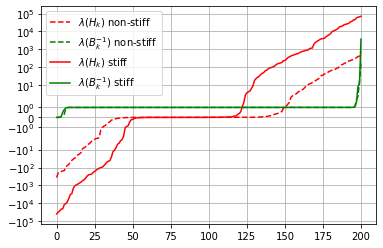

In [24]:
### Load Data ###

# non-stiff problem 
v_hess = np.loadtxt("prove_stiffness/max_cor_10/hess_eigvals.txt")
v_approx_hess = np.loadtxt("prove_stiffness/max_cor_10/approx_hess_eigvals.txt")

# stiff problem
v_hess_stiff = np.loadtxt("prove_stiffness/max_cor_10/hess_eigvals_stiff.txt")
v_approx_hess_stiff = np.loadtxt("prove_stiffness/max_cor_10/approx_hess_eigvals_stiff.txt")

# product 
# product = np.loadtxt("prove_stiffness/max_cor_10/product_eigvals.txt")
# product_stiff = np.loadtxt("prove_stiffness/max_cor_10/product_eigvals_stiff.txt")

### Plotting ###

fig,ax = plt.subplots()

# non-stiff problem
plt.plot(v_hess, '--', label = '$\lambda(H_k)$ non-stiff', color = 'red')
plt.plot(v_approx_hess, '--', label = '$\lambda(B_k^{-1})$ non-stiff', color = 'green')

# stiff problem
plt.plot(v_hess_stiff, label = '$\lambda(H_k)$ stiff', color = 'red')
plt.plot(v_approx_hess_stiff, label = '$\lambda(B_k^{-1})$ stiff', color = 'green')

# plt.plot(product, label = '$\lambda(H_k B_k^{-1})$ Non-stiff')
# plt.plot(product_stiff, label = '$\lambda(H_k B_k^{-1})$ stiff')

ax.set_yscale('symlog')
plt.legend()
plt.grid()

# plt.savefig('prove_stiffness/max_cor_10/eigenvalues_compare_max_cor_10.png', dpi = 500)

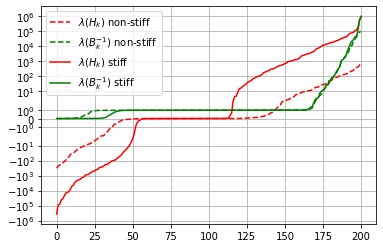

In [41]:
### Load Data ###

# non-stiff problem 
v_hess = np.loadtxt("prove_stiffness/max_cor_100/hess_eigvals.txt")
v_approx_hess = np.loadtxt("prove_stiffness/max_cor_100/approx_hess_eigvals.txt")

# stiff problem
v_hess_stiff = np.loadtxt("prove_stiffness/max_cor_100/hess_eigvals_stiff.txt")
v_approx_hess_stiff = np.loadtxt("prove_stiffness/max_cor_100/approx_hess_eigvals_stiff.txt")

### Plotting ###

fig,ax = plt.subplots()

# non-stiff problem
plt.plot(v_hess, '--', label = '$\lambda(H_k)$ non-stiff', color = 'red')
plt.plot(v_approx_hess, '--', label = '$\lambda(B_k^{-1})$ non-stiff', color = 'green')

# stiff problem
plt.plot(v_hess_stiff, label = '$\lambda(H_k)$ stiff', color = 'red')
plt.plot(v_approx_hess_stiff, label = '$\lambda(B_k^{-1})$ stiff', color = 'green')

ax.set_yscale('symlog')
plt.legend()
plt.grid()

# plt.savefig('prove_stiffness/max_cor_100/eigenvalues_compare_max_cor_100.png', dpi = 500)

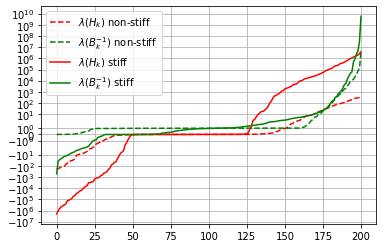

In [8]:
### Load Data ###

# non-stiff problem 
v_hess = np.loadtxt("prove_stiffness/max_cor_200/hess_eigvals.txt")
v_approx_hess = np.loadtxt("prove_stiffness/max_cor_200/approx_hess_eigvals.txt")

# stiff problem
v_hess_stiff = np.loadtxt("prove_stiffness/max_cor_200/hess_eigvals_stiff.txt")
v_approx_hess_stiff = np.loadtxt("prove_stiffness/max_cor_200/approx_hess_eigvals_stiff.txt")

### Plotting ###

fig,ax = plt.subplots()

# non-stiff problem
plt.plot(v_hess, '--', label = '$\lambda(H_k)$ non-stiff', color = 'red')
plt.plot(v_approx_hess, '--', label = '$\lambda(B_k^{-1})$ non-stiff', color = 'green')

# stiff problem
plt.plot(v_hess_stiff, label = '$\lambda(H_k)$ stiff', color = 'red')
plt.plot(v_approx_hess_stiff, label = '$\lambda(B_k^{-1})$ stiff', color = 'green')

ax.set_yscale('symlog')
plt.legend()
plt.grid()

# plt.savefig('prove_stiffness/max_cor_200/eigenvalues_compare_max_cor_200.png', dpi = 500)

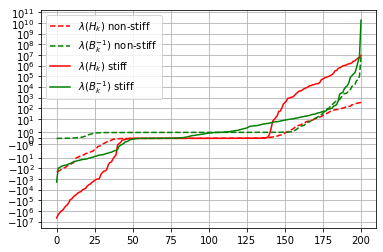

In [27]:
### Load Data ###

# non-stiff problem 
v_hess = np.loadtxt("prove_stiffness/max_cor_500/hess_eigvals.txt")
v_approx_hess = np.loadtxt("prove_stiffness/max_cor_500/approx_hess_eigvals.txt")

# stiff problem
v_hess_stiff = np.loadtxt("prove_stiffness/max_cor_500/hess_eigvals_stiff.txt")
v_approx_hess_stiff = np.loadtxt("prove_stiffness/max_cor_500/approx_hess_eigvals_stiff.txt")

### Plotting ###

fig,ax = plt.subplots()

# non-stiff problem
plt.plot(v_hess, '--', label = '$\lambda(H_k)$ non-stiff', color = 'red')
plt.plot(v_approx_hess, '--', label = '$\lambda(B_k^{-1})$ non-stiff', color = 'green')

# stiff problem
plt.plot(v_hess_stiff, label = '$\lambda(H_k)$ stiff', color = 'red')
plt.plot(v_approx_hess_stiff, label = '$\lambda(B_k^{-1})$ stiff', color = 'green')

ax.set_yscale('symlog')
plt.legend()
plt.grid()

# plt.savefig('prove_stiffness/max_cor_500/eigenvalues_compare_max_cor_500.png', dpi = 500)

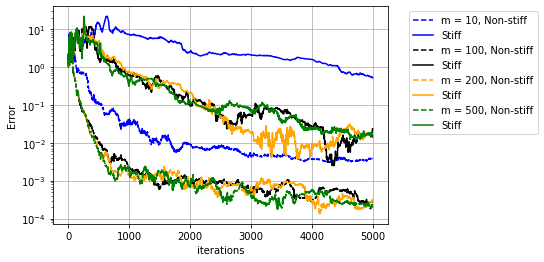

In [17]:
s1 = np.loadtxt('prove_stiffness/max_cor_10/non_stiff.txt', comments = "#", delimiter = " ", unpack = False)
s2 = np.loadtxt('prove_stiffness/max_cor_10/stiff.txt', comments = "#", delimiter = " ", unpack = False)
s3 = np.loadtxt('prove_stiffness/max_cor_100/non_stiff.txt', comments = "#", delimiter = " ", unpack = False)
s4 = np.loadtxt('prove_stiffness/max_cor_100/stiff.txt', comments = "#", delimiter = " ", unpack = False)
s5 = np.loadtxt('prove_stiffness/max_cor_200/non_stiff.txt', comments = "#", delimiter = " ", unpack = False)
s6 = np.loadtxt('prove_stiffness/max_cor_200/stiff.txt', comments = "#", delimiter = " ", unpack = False)
s7 = np.loadtxt('prove_stiffness/max_cor_500/non_stiff.txt', comments = "#", delimiter = " ", unpack = False)
s8 = np.loadtxt('prove_stiffness/max_cor_500/stiff.txt', comments = "#", delimiter = " ", unpack = False)

fig,ax = plt.subplots()

plt.semilogy(s1[:,3], '--', color = 'blue', label = 'm = 10, Non-stiff')
plt.semilogy(s2[:,3], color = 'blue', label = 'Stiff')

plt.semilogy(s3[:,3], '--', color = 'black', label = 'm = 100, Non-stiff')
plt.semilogy(s4[:,3], color = 'black', label = 'Stiff')

plt.semilogy(s5[:,3], '--', color = 'orange', label = 'm = 200, Non-stiff')
plt.semilogy(s6[:,3], color = 'orange', label = 'Stiff')

plt.semilogy(s7[:,3], '--', color = 'green', label = 'm = 500, Non-stiff')
plt.semilogy(s8[:,3], color = 'green', label = 'Stiff')

plt.xlabel('iterations')
plt.ylabel('Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

plt.savefig('prove_stiffness/compare_error_convergence_difference_with_m=max_cor.png', dpi = 500, bbox_inches='tight')